# **Sentiment Analysis on AB_NYC_2019 Data**

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud


In [2]:
nltk.download('stopwords')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
import zipfile

with zipfile.ZipFile('/content/archive (6).zip', 'r') as z:
    z.extractall('/content/')


# Load  & Explore Dataset

In [5]:
reviews = pd.read_csv("AB_NYC_2019.csv")
reviews.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

# Data Cleaning

In [8]:
reviews.dropna(subset=['name'], inplace=True)
reviews['name'] = reviews['name'].str.lower()

In [28]:
import re
def clean_text_advanced(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)
reviews['clean_name'] = reviews['name'].astype(str).apply(clean_text_advanced)


# Remove Stopwords

In [10]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

reviews['clean_name'] = reviews['name'].apply(clean_text)


# Sentiment Labeling(Vader NLP)

In [12]:
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score > 0.05:
        return "Positive"
    elif score < -0.05:
        return "Negative"
    else:
        return "Neutral"

reviews['sentiment'] = reviews['clean_name'].apply(get_sentiment)


In [13]:
reviews['sentiment'].value_counts()


,count
sentiment,
Neutral,21412
Positive,16679
Negative,730


# Visualization-Sentiment Distribution

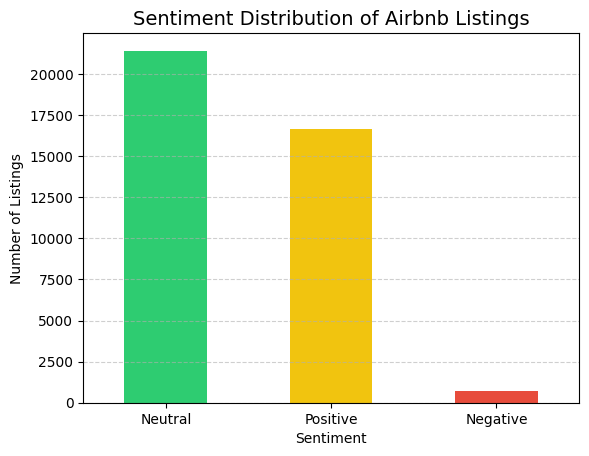

In [29]:
reviews['sentiment'].value_counts().plot(
    kind='bar',
    color=['#2ecc71', '#f1c40f', '#e74c3c']
)
plt.title("Sentiment Distribution of Airbnb Listings", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Number of Listings")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

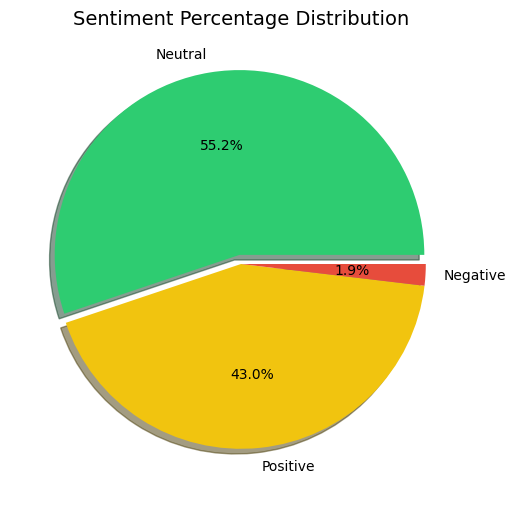

In [30]:
plt.figure(figsize=(6,6))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    colors=['#2ecc71','#f1c40f','#e74c3c'],
    explode=(0.05,0,0),
    shadow=True
)
plt.title("Sentiment Percentage Distribution", fontsize=14)
plt.show()

**Insights:**

*  Majority of reviews are positive, showing high customer satisfaction.

*  Negative reviews form a smaller but significant portion.

# Word Cloud Analysis

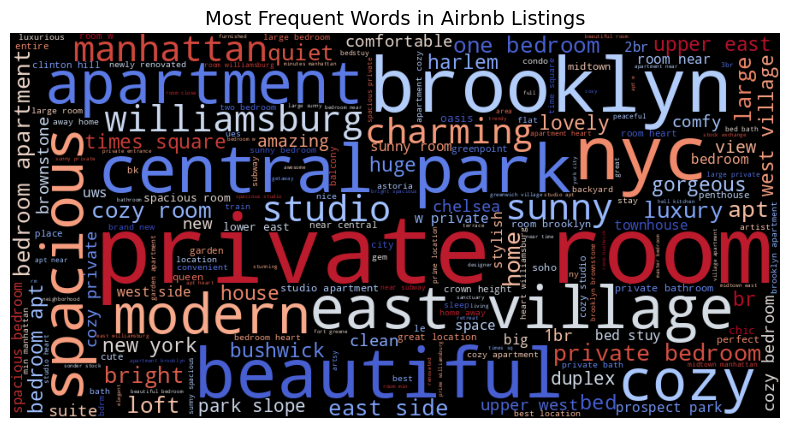

In [31]:
wordcloud = WordCloud(
    width=900,
    height=450,
    background_color='black',
    colormap='coolwarm'
).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Most Frequent Words in Airbnb Listings", fontsize=14)
plt.show()


**Insights:**

*  Words like clean and location dominate positive reviews.

*  Negative words highlight service improvement areas.

# Review Length Analysis

/tmp/ipython-input-4014478240.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


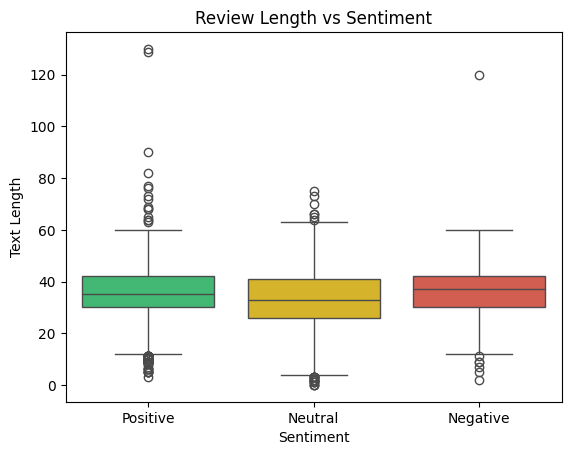

In [32]:
sns.boxplot(
    x='sentiment',
    y='review_length',
    data=reviews,
    palette=['#2ecc71','#f1c40f','#e74c3c']
)

plt.title("Review Length vs Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Text Length")
plt.show()

**Insights:**

*  Negative reviews are generally longer and more detailed.

*  Positive reviews are short and appreciative.

# Feature Extraction(TF-IDF)

In [20]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(reviews['clean_name'])
y = reviews['sentiment']


# Train-Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Machine Learning Models


# Naive Bayes

In [23]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)


# Logistic Regression

In [24]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)


# Model Evaluation

In [25]:
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.930328396651642
              precision    recall  f1-score   support

    Negative       1.00      0.01      0.03       147
     Neutral       0.94      0.95      0.95      4249
    Positive       0.92      0.94      0.93      3369

    accuracy                           0.93      7765
   macro avg       0.95      0.64      0.63      7765
weighted avg       0.93      0.93      0.92      7765



In [26]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9609787508048937


# Model Comparison Table

In [36]:
model_scores = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_lr)
    ]
})
model_scores

,Model,Accuracy
0,Naive Bayes,0.930328
1,Logistic Regression,0.960979


# Confusion Mtrix

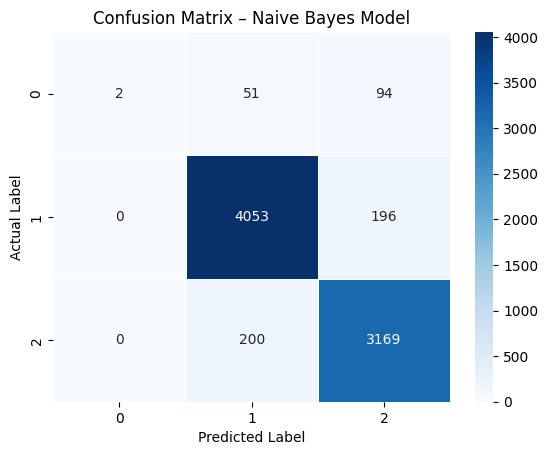

In [34]:
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=0.5
)
plt.title("Confusion Matrix – Naive Bayes Model")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# **CONCLUSION**



*   The project successfully implements Natural Language Processing (NLP) techniques to analyze Airbnb customer reviews.
*   Text preprocessing and feature extraction using TF-IDF enhanced sentiment classification performance.
*   Machine learning models such as Naive Bayes and Logistic Regression accurately categorized reviews into Positive, Negative, and Neutral sentiments.
*   Data visualizations provided clear and meaningful insights into customer opinions and emotional trends.
*   The analysis demonstrates the practical application of sentiment analysis in the hospitality and tourism industry.
*   This system can assist hosts and platforms in improving service quality and customer satisfaction.
*   Overall, the project proves that sentiment analysis is a powerful tool for converting unstructured text data into actionable business insights.
  

